In [13]:
import tensorflow as tf
if not tf.executing_eagerly():
    tf.enable_eager_execution()

In [14]:
from scipy.signal import fftconvolve
from astropy.io import fits
import numpy as np
import math
from pathlib import Path
from io import BytesIO
import matplotlib.pyplot as plt
from vacuum.model import create_model
from vacuum.io_ import load_data, preprocess, deprocess, fits_open
%matplotlib inline

In [15]:
INPUT_DIR = "/scratch/datasets/meerkat16_deep2like_morerange/"

In [16]:
batch, count = load_data(INPUT_DIR)
iter = batch.make_one_shot_iterator()
index, min_flux, max_flux, psf, dirty, skymodel = iter.get_next()

In [17]:
scaled_dirty = preprocess(dirty, min_flux, max_flux)
scaled_skymodel = preprocess(skymodel, min_flux, max_flux)
scaled_psf = preprocess(psf, min_flux, max_flux)

In [18]:
def gaussian_kernel(size: int, mean: float, std: float, ):
    d = tf.distributions.Normal(mean, std)
    vals = d.prob(tf.range(start = -size, limit=size+1, dtype=tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', vals, vals)
    return gauss_kernel / tf.reduce_max(gauss_kernel)
    #return gauss_kernel / tf.reduce_sum(gauss_kernel)

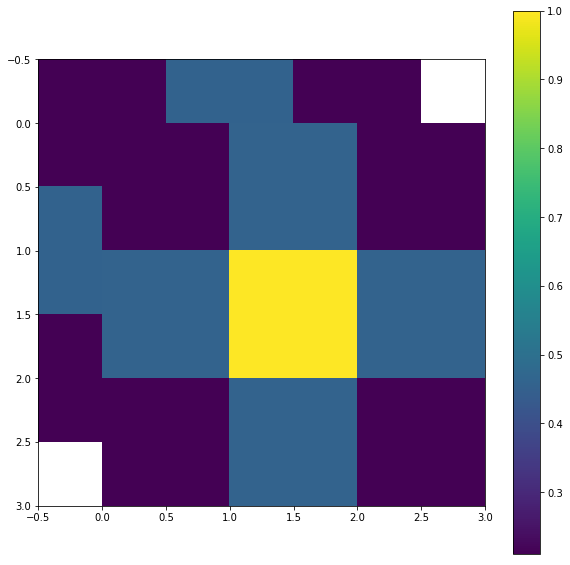

In [47]:
gauss_kernel = gaussian_kernel( 1, 0.0, 0.8 )[:, :, tf.newaxis, tf.newaxis]
x = tf.nn.conv2d(skymodel, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tf.squeeze(gauss_kernel))
_ = fig.colorbar(ax.pcolor(tf.squeeze(gauss_kernel)), ax=ax)

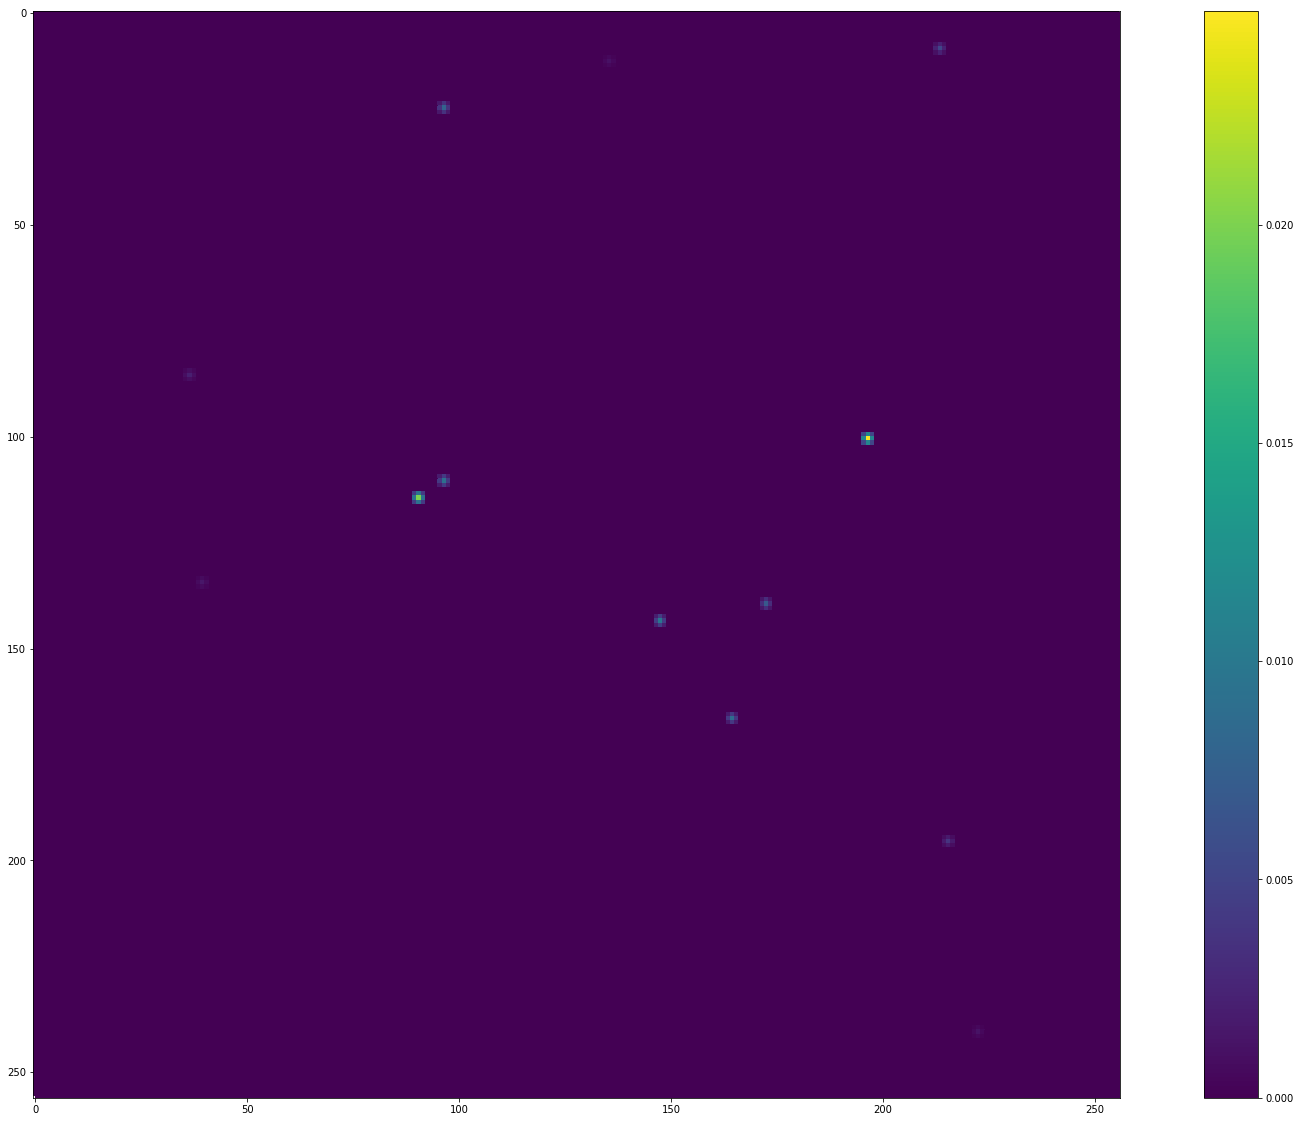

In [48]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow(tf.squeeze(x))
_ = fig.colorbar(ax.pcolor(tf.squeeze(x)), ax=ax)

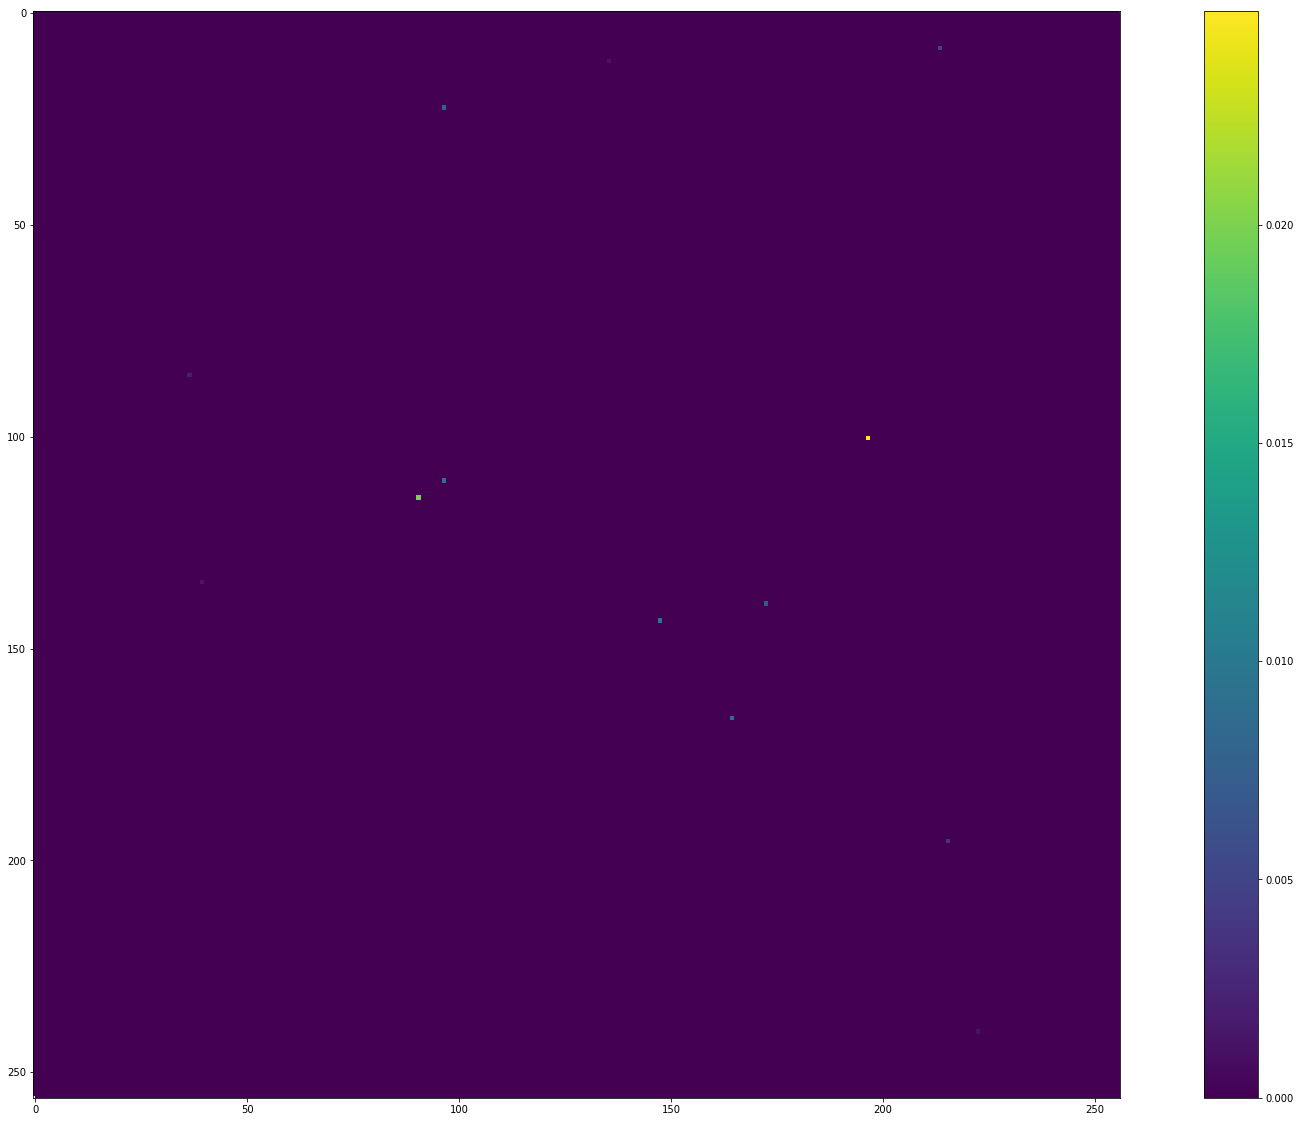

In [45]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow(tf.squeeze(skymodel))
_ = fig.colorbar(ax.pcolor(tf.squeeze(skymodel)), ax=ax)

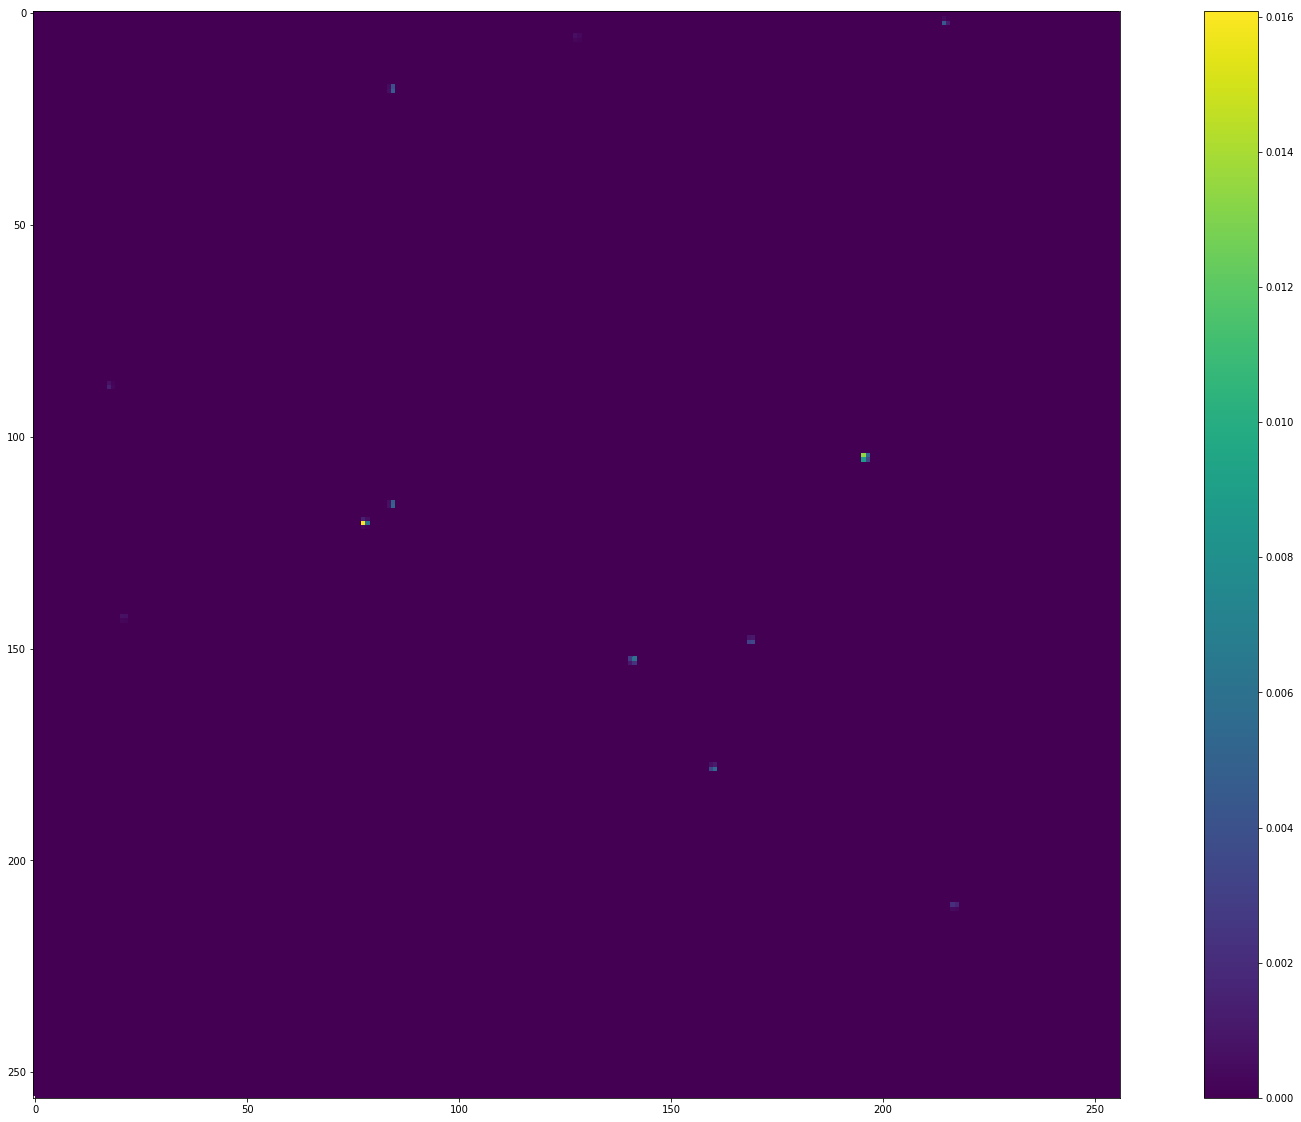

In [44]:
scale_size = 285
crop_size = 256
seed = 1
scaled = tf.image.resize_images(skymodel, [scale_size, scale_size], method=tf.image.ResizeMethod.AREA)
offset = tf.cast(tf.floor(tf.random_uniform([2], 0, scale_size - crop_size + 1, seed=seed)), dtype=tf.int32)
scaled = tf.image.crop_to_bounding_box(scaled, offset[0], offset[1], crop_size, crop_size)

fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow(tf.squeeze(scaled))
_ = fig.colorbar(ax.pcolor(tf.squeeze(scaled)), ax=ax)